# T아카데미 강의

# tensorflow2.0

### -특징
+ excution 이 default -> session이 없어짐
+ function
+ autograph ->  그래프 모드 -> 속도가 빨라짐(최적화)
+ keras python api
+ global 사라짐

### autograph
+ @tf.function
 함수 앞에 적용decorate를 불이면 debuging어려움 -> 먼저 실행 후 붙여서 학습


### Sequential API
+ add 로 layer쌓음
+ compile
+ fit : 모델 훈련
+ evaluate : 평가
+ predict : 예측

### function API
+ INPUT layer 에 (name도 정해야)

In [1]:
import tensorflow as tf

w = tf.Variable(2.0, name="weight")
b = tf.Variable(0.7,name="bias")

for x in [1.0,0.6,-1.0]:
    z = w*x+b
    print ('x=%4.1f ----> z=%4.1f'%(x,z))

x= 1.0 ----> z= 2.7
x= 0.6 ----> z= 1.9
x=-1.0 ----> z=-1.3


# tensorflow 

#### 수학
matmul 등으로 행렬 계산 해야됨, shape이 안맞아도 broad casting으로 계산이 되버림

In [2]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
    tape.watch(a)  # `a`에 적용되는 연산의 히스토리에 대한 기록을 시작
    c = tf.sqrt(tf.square(a) + tf.square(b))  # `a`를 사용하여 몇 가지 수학을 수행
    dc_da = tape.gradient(c, a) #a로 미분
    print(dc_da)
    
## variable로 선언해 주면 watch를 선언할 필요 x
# a = tf.Variable(a)
# tape을 중첩되게 하여 n차 미분이 가능

tf.Tensor(
[[ 0.1319912   0.45737234]
 [-0.4882933  -0.23031543]], shape=(2, 2), dtype=float32)


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# 부분을 정해서 따로 분리하는게 교체할 때 편함

# hyper parameter
input_dim = 2
output_dim = 1
learning_rate = 0.01

#변수 선언, 데이터 
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
    return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
    return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        predictions = compute_predictions(x)
        loss = compute_loss(y, predictions)
        dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    w.assign_sub(learning_rate * dloss_dw)
    b.assign_sub(learning_rate * dloss_db)
    return loss

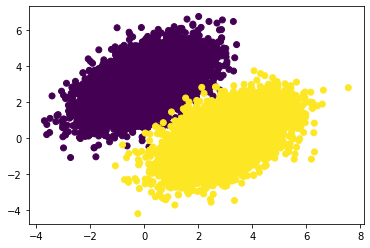

In [4]:
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

In [5]:
# 같은 SEED로 나누기
random.Random(1337).shuffle(features)
random.Random(1337).shuffle(labels)

# 손쉽게 배치화된 반복을 위해, tf.data.Dataset 객체를 생성합니다
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
    for step, (x, y) in enumerate(dataset):
        loss = train_on_batch(x, y)
    print('Epoch %d: 마지막 배치의 손실값 = %.4f' % (epoch, float(loss)))

Epoch 0: 마지막 배치의 손실값 = 0.0812
Epoch 1: 마지막 배치의 손실값 = 0.0614
Epoch 2: 마지막 배치의 손실값 = 0.0672
Epoch 3: 마지막 배치의 손실값 = 0.0359
Epoch 4: 마지막 배치의 손실값 = 0.0238
Epoch 5: 마지막 배치의 손실값 = 0.0246
Epoch 6: 마지막 배치의 손실값 = 0.0262
Epoch 7: 마지막 배치의 손실값 = 0.0348
Epoch 8: 마지막 배치의 손실값 = 0.0256
Epoch 9: 마지막 배치의 손실값 = 0.0153


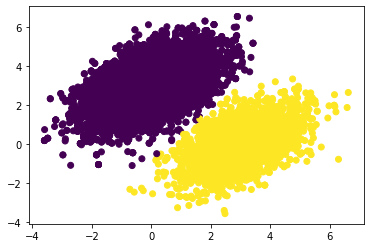

In [6]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

In [7]:
import time

t0 = time.time()
for epoch in range(20):
    for step, (x, y) in enumerate(dataset):
        loss = train_on_batch(x, y)
t_end = time.time() - t0
print('epoch당 걸린 시간: %.3f 초' % (t_end / 20,))


epoch당 걸린 시간: 0.221 초


In [8]:
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        predictions = compute_predictions(x)
        loss = compute_loss(y, predictions)
        dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    w.assign_sub(learning_rate * dloss_dw)
    b.assign_sub(learning_rate * dloss_db)
    return loss

In [9]:
t0 = time.time()
for epoch in range(20):
    for step, (x, y) in enumerate(dataset):
        loss = train_on_batch(x, y)
t_end = time.time() - t0
print('epoch당 걸린 시간: %.3f 초' % (t_end / 20,))


epoch당 걸린 시간: 0.093 초


# keras API

In [12]:
from tensorflow.keras.layers import Layer

class Linear(Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

linear_layer = Linear(4)

# 이렇게 하면, `build(input_shape)`이 호출되어 가중치를 생성하게 됩니다.
y = linear_layer(tf.ones((2, 2)))
assert len(linear_layer.weights) == 2

In [14]:
class MLP(Layer):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)
# Layer를 3개로 쌓임
    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)
     # layer마다 relu 적용

mlp = MLP()

y = mlp(tf.ones(shape=(3, 64)))

# 가중치들은 재귀적으로 추적됩니다.
assert len(mlp.weights) == 6

[<tf.Variable 'mlp_1/linear_4/Variable:0' shape=(64, 32) dtype=float32, numpy=
 array([[-0.04922086, -0.02762533,  0.04075914, ..., -0.02501374,
         -0.07622997, -0.05934349],
        [-0.05476531,  0.04309303,  0.04677476, ...,  0.02277638,
         -0.02153209, -0.01890301],
        [-0.09919095,  0.01195783,  0.05479253, ..., -0.03176193,
          0.01219523,  0.00213669],
        ...,
        [ 0.04184305,  0.00220736,  0.0275724 , ...,  0.0306095 ,
         -0.00184015,  0.01092613],
        [ 0.02355872, -0.01987569,  0.04557459, ..., -0.08851174,
          0.08248376,  0.00897327],
        [ 0.03881637,  0.04887088,  0.00928155, ..., -0.03943485,
          0.06928403, -0.04755396]], dtype=float32)>,
 <tf.Variable 'mlp_1/linear_4/Variable:0' shape=(32,) dtype=float32, numpy=
 array([ 0.0071314 ,  0.07347756, -0.08382941, -0.05084493, -0.01281456,
        -0.06478976,  0.12195065, -0.08597785, -0.03606184,  0.0389314 ,
         0.06150243,  0.01779114,  0.07726931, -0.001778

+ dropout,, batch normalization에서 call에서 training인자를 설정해야함
 test에서는 train에서 계산한 데이터를 쓰기 때문에

### Function API

In [16]:
class Dropout(Layer):
  
    def __init__(self, rate):
        super(Dropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

class MLPWithDropout(Layer):

    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.linear_1 = Linear(32)
        self.dropout = Dropout(0.5)
        self.linear_3 = Linear(10)

    def call(self, inputs, training=None):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return self.linear_3(x)
    
mlp = MLPWithDropout()
y_train = mlp(tf.ones((2, 2)), training=True)
y_test = mlp(tf.ones((2, 2)), training=False)

### metric
Loss와는 다르게 Metric은 상태를 가짐 update_state 메소드를 사용해서 상태를 갱신하고 result를 사용해서 스칼라형태의 결과값을 요청할 수 있습니다:

In [17]:
from tensorflow.keras import Sequential

model = Sequential([Linear(32), Dropout(0.5), Linear(10)])

y = model(tf.ones((2, 16)))

m = tf.keras.metrics.AUC()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('중간 결과: ', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('최종 결과: ', m.result().numpy())

중간 결과:  0.6666667
최종 결과:  0.71428573


In [18]:
from tensorflow.keras import layers

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:].reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu), # 'relu'처럼 string으로 사용가능
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10, activation = 'softmax')
])

# 정수형 레이블을 인자로 받아들이는, 로지스틱 Loss의 인스턴스를 만듭니다
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# 정확도에 대한 Metric의 인스턴스를 만듭니다
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Sparse 가없으면 ont-hot 일때임

# Optimizer의 인스턴스를 만듭니다
optimizer = tf.keras.optimizers.Adam()

# 데이터셋의 데이터 배치를 순회합니다
for step, (x, y) in enumerate(dataset):
  
  # GradientTape 열어줍니다
    with tf.GradientTape() as tape:

    # 순방향 전파(forward)를 수행합니다
          logits = model(x)

    # 현재 배치에 대한 손실값을 측정합니다
          loss_value = loss(y, logits)
     
  # 손실에 대한 가중치의 경사도를 계산합니다
    gradients = tape.gradient(loss_value, model.trainable_weights)
  
  # 모델의 가중치를 갱신합니다
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # 현재까지 수행된 전체에 대한 모델의 정확도를 갱신합니다
    accuracy.update_state(y, logits)
  
  # 로그를 출력합니다
    if step % 100 == 0:
        print('단계(Step):', step)
        print('마지막 단계(Step)의 손실:', float(loss_value))
        print('지금까지 수행된 전체에 대한 정확도:', float(accuracy.result()))

단계(Step): 0
마지막 단계(Step)의 손실: 2.3328375816345215
지금까지 수행된 전체에 대한 정확도: 0.109375
단계(Step): 100
마지막 단계(Step)의 손실: 0.17475712299346924
지금까지 수행된 전체에 대한 정확도: 0.843440592288971
단계(Step): 200
마지막 단계(Step)의 손실: 0.2350461483001709
지금까지 수행된 전체에 대한 정확도: 0.8788868188858032
단계(Step): 300
마지막 단계(Step)의 손실: 0.3283679783344269
지금까지 수행된 전체에 대한 정확도: 0.895348846912384
단계(Step): 400
마지막 단계(Step)의 손실: 0.16792117059230804
지금까지 수행된 전체에 대한 정확도: 0.907652735710144
단계(Step): 500
마지막 단계(Step)의 손실: 0.12086717784404755
지금까지 수행된 전체에 대한 정확도: 0.9162300229072571
단계(Step): 600
마지막 단계(Step)의 손실: 0.10643480718135834
지금까지 수행된 전체에 대한 정확도: 0.9225769639015198
단계(Step): 700
마지막 단계(Step)의 손실: 0.12386712431907654
지금까지 수행된 전체에 대한 정확도: 0.9276925921440125
단계(Step): 800
마지막 단계(Step)의 손실: 0.08378095179796219
지금까지 수행된 전체에 대한 정확도: 0.9309066534042358
단계(Step): 900
마지막 단계(Step)의 손실: 0.08909551054239273
지금까지 수행된 전체에 대한 정확도: 0.9344998598098755


In [19]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

accuracy.reset_states()  # 이 코드는 Metric의 내부 상태를 초기화 합니다
# 하지 않으면 train꺼까지 합해짐
for step, (x, y) in enumerate(test_dataset):
    logits = model(x)
    accuracy.update_state(y, logits)

print('최종 테스트 정확도:', float(accuracy.result()))

최종 테스트 정확도: 0.9682999849319458
